# Testing point-to-field operators in package `ViscousFlow`

In [4]:
using ViscousFlow

In [5]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [6]:
using Compat
using Compat: range

### Testing body-to-field operations

Here are some discrete Dirac delta functions

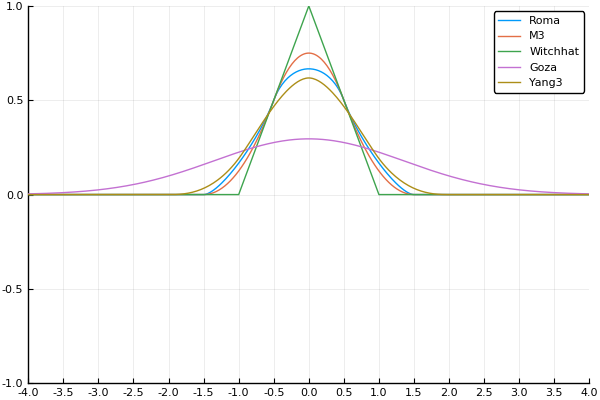

In [7]:
ddf = DDF();
x = range(-4,stop=4,length=401);
plt = plot(x,ddf.(x),label="Roma",ylim=(-1,1),xlim=(-4,4),xticks=-4:0.5:4,grid=:on)
ddf2 = DDF(ddftype=Fields.M3);
plot!(plt,x,ddf2.(x),label="M3")
ddf4 = DDF(ddftype=Fields.Witchhat);
plot!(plt,x,ddf4.(x),label="Witchhat")
ddf5 = DDF(ddftype=Fields.Goza);
plot!(plt,x,ddf5.(x),label="Goza")
ddf6 = DDF(ddftype=Fields.Yang3)
plot!(plt,x,ddf6.(x),label="Yang3")
plot(plt)

and here are the derivatives of these function

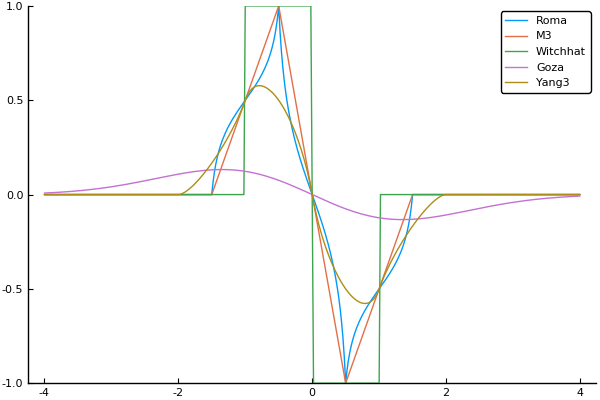

In [8]:
d_ddf = GradDDF(1);
x = range(-4,stop=4,length=401);
plt = plot(x,d_ddf.(x),label="Roma",ylim=(-1,1))
d_ddf2 = GradDDF(1,ddftype=Fields.M3);
plot!(plt,x,d_ddf2.(x),label="M3")
d_ddf4 = GradDDF(1,ddftype=Fields.Witchhat);
plot!(plt,x,d_ddf4.(x),label="Witchhat")
d_ddf5 = GradDDF(1,ddftype=Fields.Goza);
plot!(plt,x,d_ddf5.(x),label="Goza")
d_ddf6 = GradDDF(1,ddftype=Fields.Yang3);
plot!(plt,x,d_ddf6.(x),label="Yang3")

In [9]:
x = [0.25,0.75,0.25]; y = [0.75,0.25,0.25];
X = VectorData(x,y);
q = Edges(Primal,(12,12));
dx = 0.1;
H = Regularize(x,y,dx)

Regularization/interpolation operator with non-filtered interpolation
  3 points in grid with cell area 0.01


#### Set up a circle of points

In [10]:
n = 157;
θ = range(0,stop=2π,length=n+1);
R = 0.5
x = 1.0 .+ R*cos.(θ[1:n])
y = 1.0 .+ R*sin.(θ[1:n])
ds = 2π/n*R
X = VectorData(x,y);
f = ScalarData(X);

#### Set up the physical dimensions of the grid and create empty data

In [11]:
nx = 102; ny = 102;
Lx = 2.0;
dx = Lx/(nx-2);
q = Edges(Primal,(nx,ny));
w = Nodes(Dual,(nx,ny));
w̃ = Nodes(Primal,w);
p = Edges(Dual,w);

#### Create a regularization operator with the point data

In [12]:
H = Regularize(X,dx;weights=ds)

Regularization/interpolation operator with non-filtered interpolation
  157 points in grid with cell area 0.0004


In [13]:
H̃ = Regularize(X,dx;weights=ds,filter=true)

Regularization/interpolation operator with filtered interpolation
  157 points in grid with cell area 0.0004


#### Now set up some data on the points and regularize it to primal edge data on the grid 

In [16]:
f = VectorData(X)
fill!(f.u,1.0);
f.v .= X.v.-1.0;
@time H(q,f);

  0.001136 seconds (40.26 k allocations: 629.156 KiB)


We can also create a matrix representation of the regularization, and apply it:

In [20]:
@time Hmat = RegularizationMatrix(H,f,q);

  0.234114 seconds (6.33 M allocations: 117.228 MiB, 6.54% gc time)


Notice that it is a lot faster:

In [22]:
@time q = Hmat*f;

  0.000041 seconds (9 allocations: 161.344 KiB)


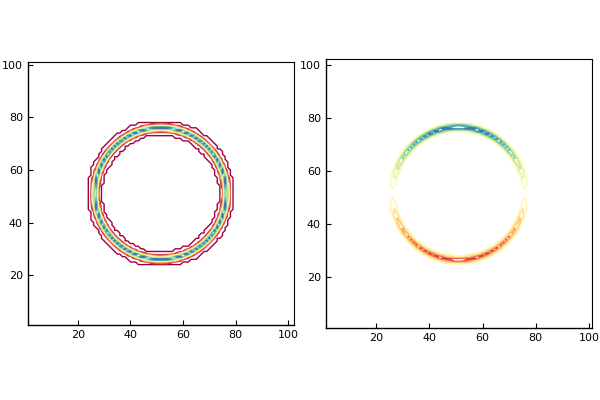

In [23]:
plot(q)

  0.055331 seconds (137.13 k allocations: 5.714 MiB)


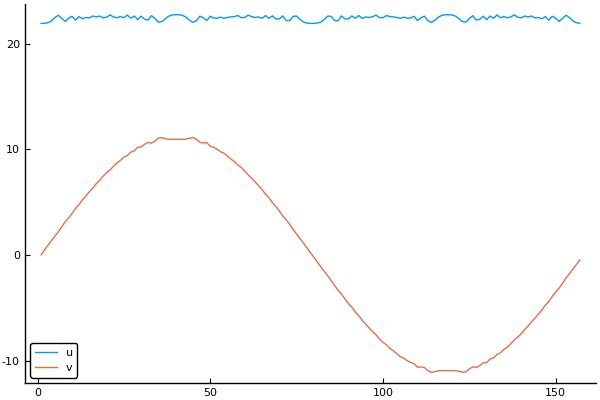

In [24]:
f2 = VectorData(X);
@time H(f2,q);
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

In [25]:
Emat = InterpolationMatrix(H,q,f2);

  0.035182 seconds (92.41 k allocations: 4.894 MiB)


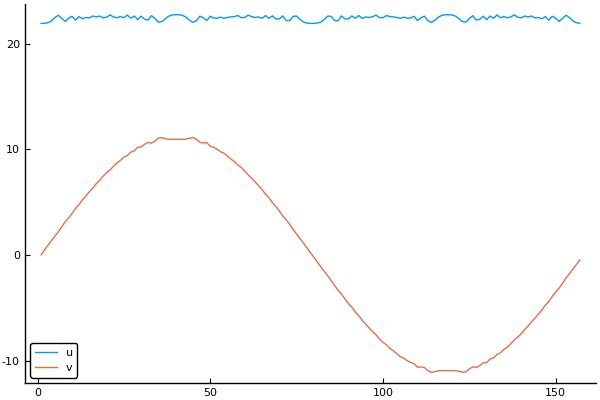

In [26]:
@time f2 = Emat*q
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Try a different kernel

In [27]:
H2 = Regularize(X,dx;weights=ds,ddftype=Fields.Roma)

Regularization/interpolation operator with non-filtered interpolation
  157 points in grid with cell area 0.0004


In [28]:
H̃2 = Regularize(X,dx;weights=ds,filter=true,ddftype=Fields.Yang3)

Regularization/interpolation operator with filtered interpolation
  157 points in grid with cell area 0.0004


In [29]:
H2mat = RegularizationMatrix(H2,f,q);
H̃2mat = RegularizationMatrix(H̃2,f,q);

  0.000033 seconds (9 allocations: 161.344 KiB)


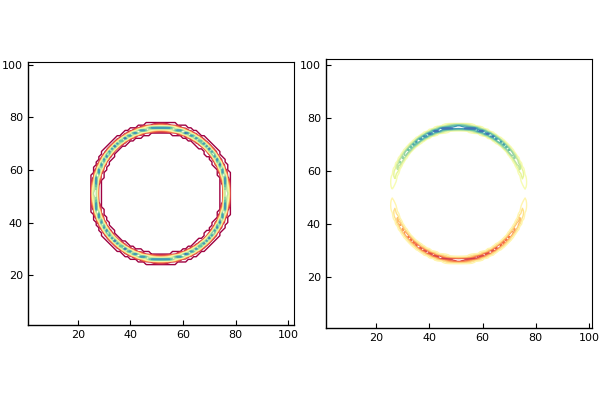

In [30]:
@time q = H2mat*f;
plot(q)

  0.000037 seconds (9 allocations: 161.344 KiB)


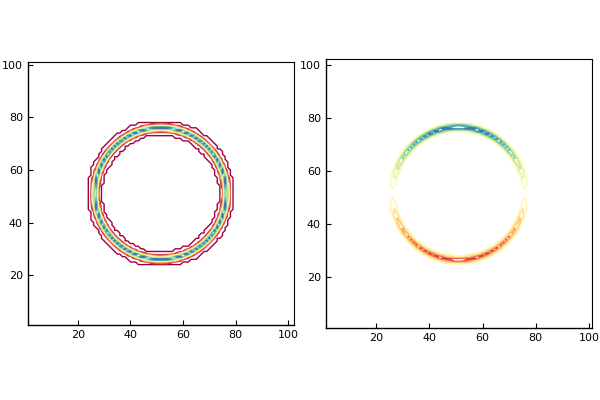

In [31]:
@time q = H̃2mat*f;
plot(q)

In [32]:
E2mat = InterpolationMatrix(H2,q,f2);

  0.000026 seconds (9 allocations: 5.500 KiB)


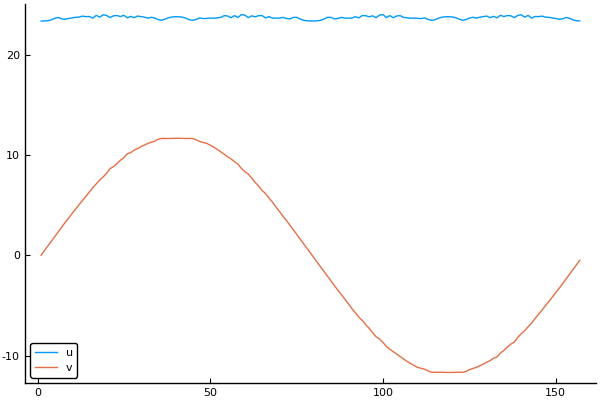

In [33]:
@time f2 = E2mat*q
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Vector data onto dual edge field

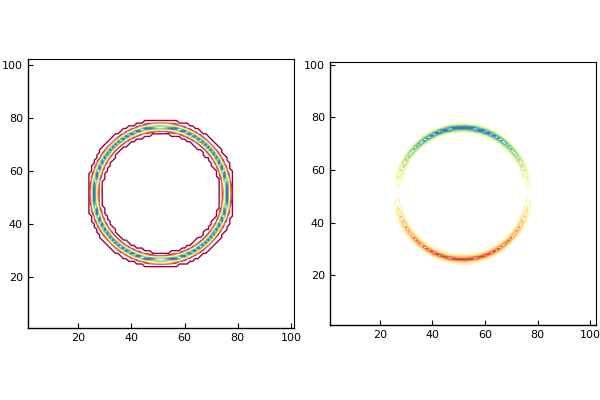

In [34]:
H(p,f);
plot(p)

#### Vector data onto primal and dual nodal data

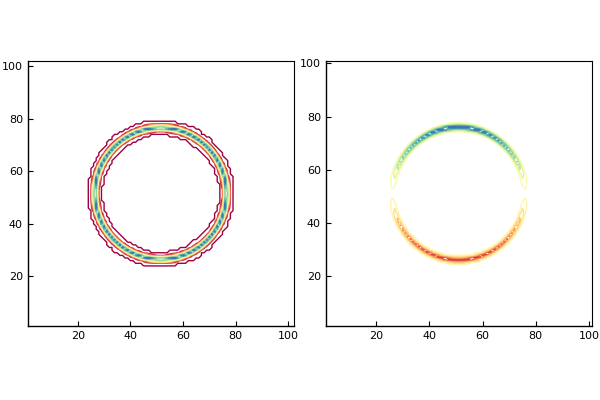

In [35]:
wpair = NodePair(Dual,Primal,(nx,ny))
H(wpair,f);
plot(wpair)

In [36]:
Hmat = RegularizationMatrix(H,f,wpair);

  0.179972 seconds (481.00 k allocations: 23.198 MiB, 5.83% gc time)


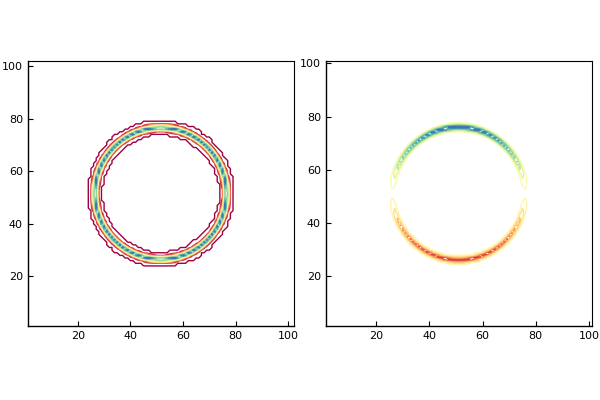

In [37]:
@time wpair .= Hmat*f
plot(wpair)

In [38]:
wpair.u .= rand(Float64,size(wpair.u));
wpair.v .= rand(Float64,size(wpair.v));

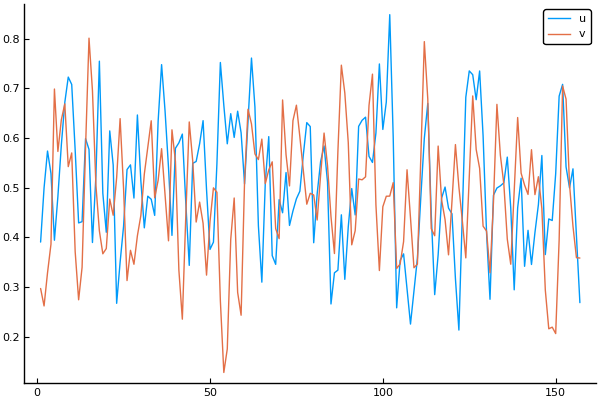

In [39]:
f2 = VectorData(X);
H(f2,wpair);
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Tensor data onto edge gradient field

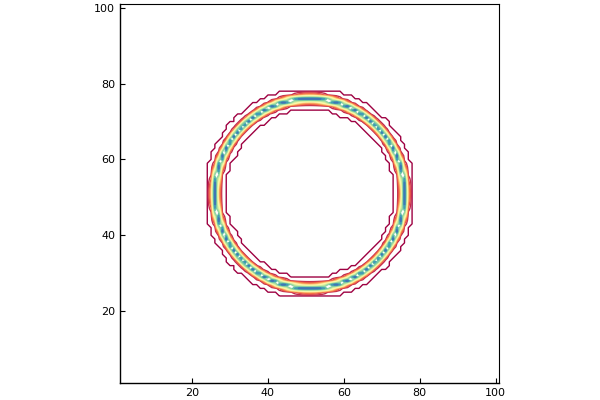

In [40]:
g = TensorData(X)
fill!(g.dudx,1.0)
fill!(g.dvdx,1.0)
gradq = EdgeGradient(Primal,size(w))
H(gradq,g)
plot(gradq.dudx)

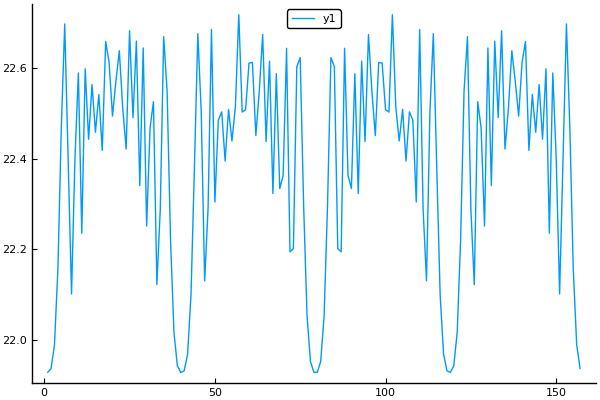

In [41]:
H(g,gradq)
plot(g.dvdx)

In [42]:
Hmat = RegularizationMatrix(H,g,gradq);

  0.204539 seconds (612.04 k allocations: 28.203 MiB, 7.54% gc time)


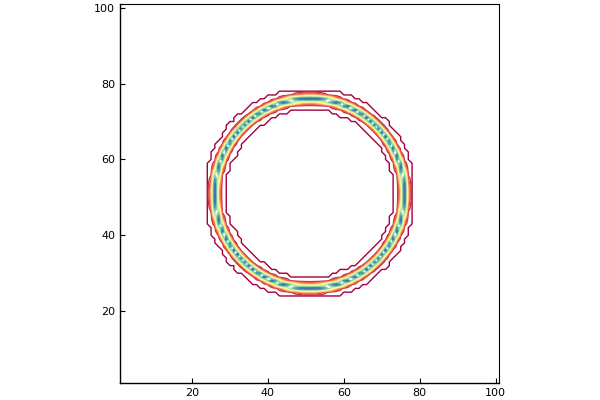

In [43]:
@time gradq .= Hmat*g
plot(gradq.dudx)

#### Scalar data onto dual nodal field

  0.039646 seconds (106.65 k allocations: 4.708 MiB)


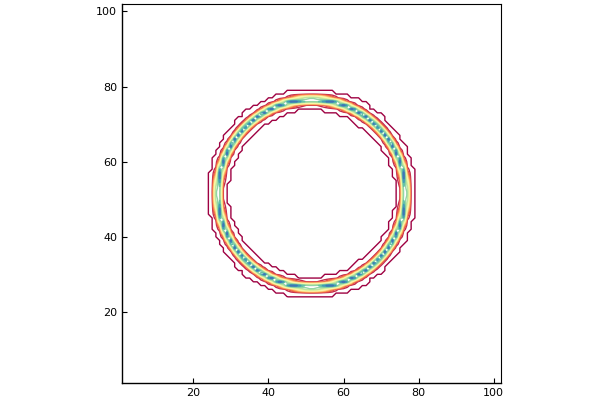

In [44]:
g = ScalarData(X)
fill!(g,1.0)
@time H(w,g)
plot(w)

#### Set up a matrix form of regularization

In [45]:
g = ScalarData(X)
w = Nodes(Dual,(nx,ny));
@time Hmat = RegularizationMatrix(H,g,w);
@time Emat = InterpolationMatrix(H,w,g);

  0.275260 seconds (3.54 M allocations: 74.274 MiB, 12.05% gc time)
  0.128139 seconds (3.20 M allocations: 57.583 MiB, 7.58% gc time)


In [46]:
using LinearAlgebra

  0.020283 seconds (48.09 k allocations: 2.359 MiB)


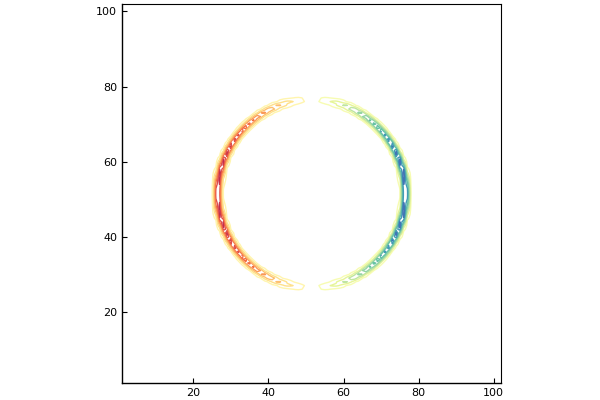

In [47]:
g = ScalarData(X)
g .= X.u .- 1.0
@time mul!(w,Hmat,g)
plot(w)

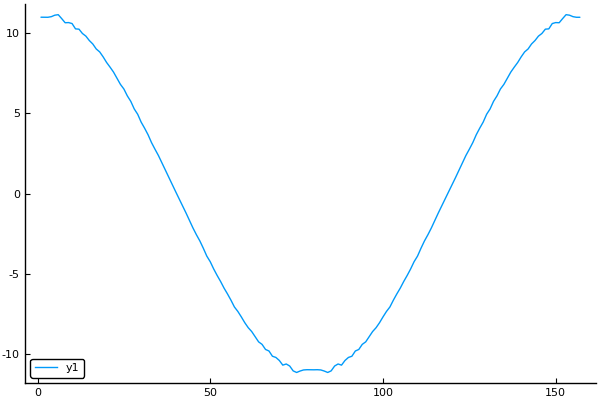

In [48]:
plot(Emat*w)

In [49]:
g = ScalarData(X)
g .= cos.(θ[1:n]) .+ 0.2*rand(n);

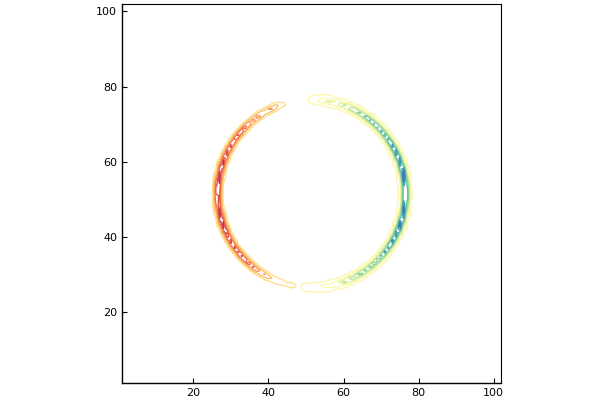

In [50]:
plot(Hmat*g)

In [52]:
g2 = ScalarData(X)
@time H(g2,w);

  0.000625 seconds (20.10 k allocations: 314.156 KiB)


In [53]:
Ẽmat = InterpolationMatrix(H̃,w,g);

  0.001571 seconds (60.30 k allocations: 1023.563 KiB)


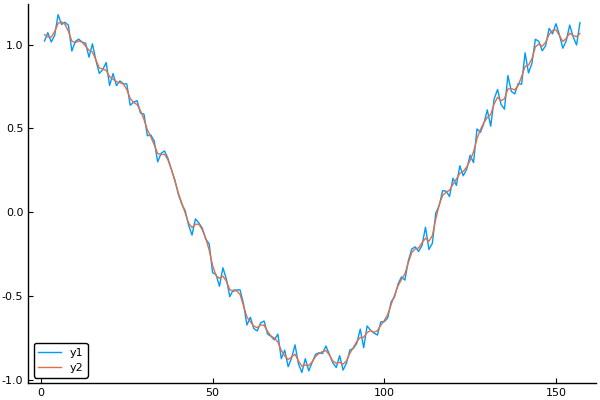

In [55]:
@time H̃(g2,H(w,g));
plot(g)
plot!(g2)

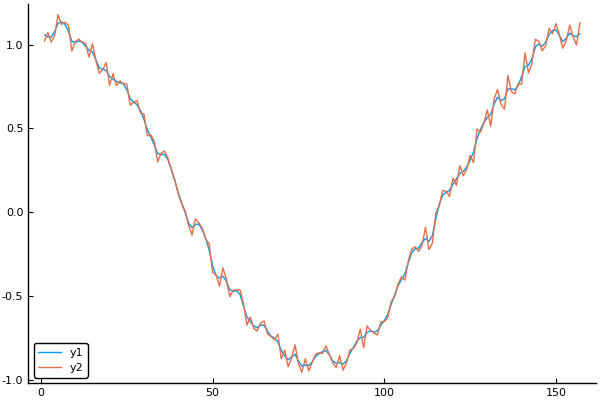

In [56]:
plot(Ẽmat*(Hmat*g))
plot!(g)

In [57]:
using SparseArrays
C = sparse(Ẽmat*Hmat)
nothing

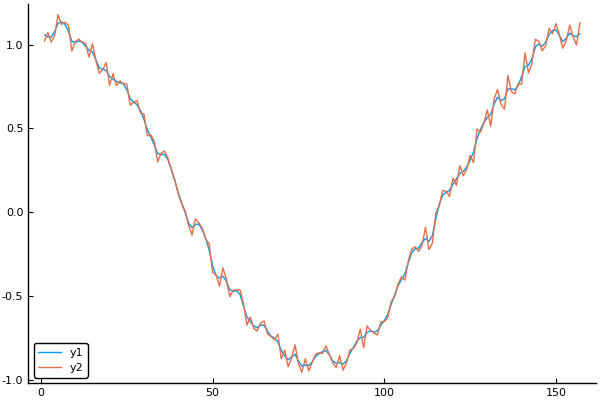

In [58]:
plot(C*g)
plot!(g)

#### Regularization and interpolation without weights

In [59]:
Huw = Regularize(X,dx;issymmetric=true)
H̃uw = Regularize(X,dx;filter=true,weights=dx*dx)

Regularization/interpolation operator with filtered interpolation
  157 points in grid with cell area 0.0004


In [60]:
g = ScalarData(X)
g .= cos.(θ[1:n]) .+ 0.2*rand(n);
@time Huwmat, Euwmat = RegularizationMatrix(Huw,g,w);

  0.118394 seconds (3.16 M allocations: 55.409 MiB, 13.10% gc time)


In [61]:
@time H̃uwmat = RegularizationMatrix(H̃uw,g,w);
@time Ẽuwmat = InterpolationMatrix(H̃uw,w,g);

  0.141093 seconds (3.21 M allocations: 57.714 MiB, 12.26% gc time)
  0.107575 seconds (3.18 M allocations: 57.438 MiB, 9.28% gc time)


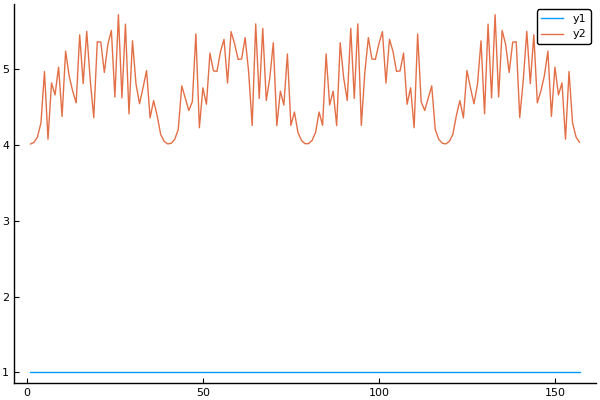

In [62]:
fill!(w,1)
plot(Euwmat*w)
plot!(Ẽuwmat*w)

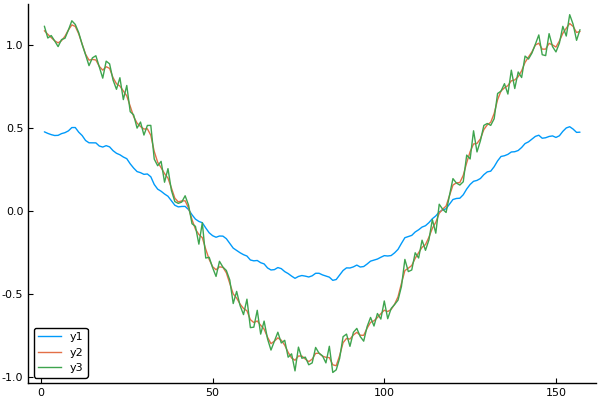

In [63]:
plot(Euwmat*(Huwmat*g))
plot!(Ẽuwmat*(Huwmat*g))
plot!(g)

#### Derivative of DDF

Seek an interface in which each component of a spatial gradient operator is given a distinct type. Should also build from (and be connected to) the basic ddf kernel.

In [64]:
d_ddf(1)

-0.5

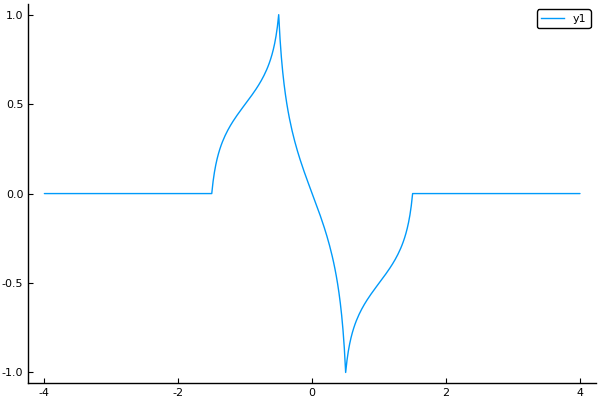

In [65]:
r = range(-4,4,length=401)
plot(r,d_ddf.(r))

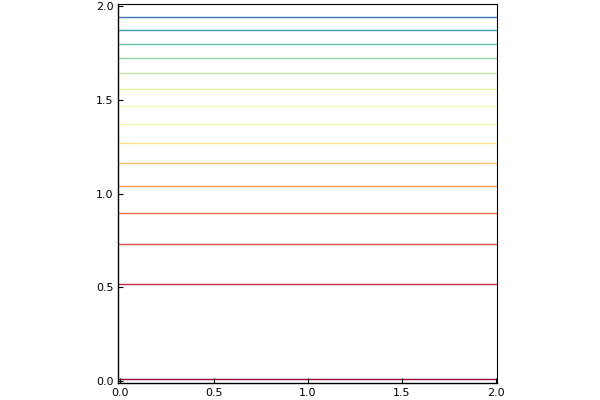

In [79]:
w = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w,dx=dx)
w .= transpose(yg).^2
plot(xg,yg,w)

Note that the interpolation part of the regularization operator does not use any weights. So the result must be explicitly divided by the grid spacing.

In [81]:
dHy = Regularize(X,dx,graddir=2)

Regularization/interpolation operator with non-filtered interpolation
  157 points in grid with cell area 0.0004


In [86]:
f = ScalarData(X);

In [87]:
dHy(f,w)

157 points of scalar-valued data
157-element Array{Float64,1}:
 -0.03999999999999995 
 -0.040800192130609265
 -0.04159910282574436 
 -0.04239545270203399 
 -0.04318796647702822 
 -0.04397537501144511 
 -0.044756417341586766
 -0.045529842698655495
 -0.04629441251174935 
 -0.04704890239132095 
 -0.047792104089925076
 -0.04852282743712097 
 -0.04923990224542076 
  ⋮                   
 -0.030760097754578844
 -0.031477172562878984
 -0.032207895910074905
 -0.032951097608678925
 -0.033705587488250185
 -0.03447015730134426 
 -0.03524358265841318 
 -0.036024624988555035
 -0.03681203352297217 
 -0.037604547297965765
 -0.038400897174255544
 -0.03919980786939071 

In [89]:
dHymat = RegularizationMatrix(dHy,f,w);
dEymat = InterpolationMatrix(dHy,w,f);

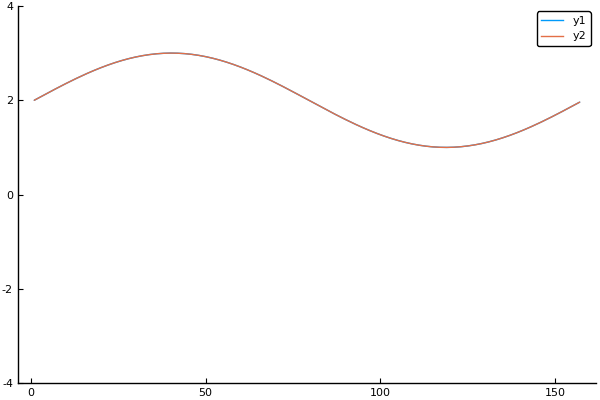

In [90]:
plot(-(dEymat*w)/dx,ylim=(-4,4))
plot!(2*X.v)

In [91]:
w2 = Nodes(Dual,w)
f .= X.v
w2 .= dHymat*f

Nodes{Dual,102,102} data
Printing in grid orientation (lower left is (1,1))
102×102 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 